# Idea
Do some feature ranking. 

**BUT**: SYSTE needs addional feature engineering.

**REMARKS**: addional parameter to show which version of system (0:old-simple bow; 1: process-syscall info; 2: 2-gram)

| **Possible DataSources** |
| --- |
| SYS_data |
| KERN_data |
| FLS_data |
| RES_data |
| block_data |
| network_data |
| entropy_data |


In [ ]:
DATA_SOURCE = "SYS_data"
DEVICE_SOURCE = "Heqing_device2"

In [ ]:
from enum import Enum

class SystemVersion(Enum):
    OLD_BOW = 'old-bow'
    PROCESS_INFO = 'process_info'
    TWO_GRAM = '2-gram'

VERSION = SystemVersion.PROCESS_INFO

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

In [ ]:
import sys
repo_base_path = Path("./../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))

from py_dataset import get_all_files_df
from py_dataset import read_in_files
from py_dataset import feature_plotting
from py_dataset import feature_selection

from py_dataset import sys_func
# from py_dataset import net_feature_engineering

# Loading Sys Data

##### 1. normal: bow

In [ ]:
if VERSION != SystemVersion.OLD_BOW:
    raise NotImplementedError("Only OLD_BOW is implemented")


file_path = Path('/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/merged_data.npz')
assert file_path.exists(), 'Data not found'

with np.load(file_path, allow_pickle=True) as npz:
    print(npz.files)
    X = npz['arr_0']
print(X.shape)

vectorizer = sys_func.create_CountVectorizer()
cols = vectorizer.get_feature_names_out()
cols = np.append(cols, [['timestamp'], ['label']])
print (cols.shape)
df = pd.DataFrame(X, columns=cols)
df.set_index('timestamp', inplace=True)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

vectors = df.copy()
print(vectors.shape)
vectors.head(1)

##### 2. using process-sys_call information

In [70]:
if VERSION != SystemVersion.PROCESS_INFO:
    raise NotImplementedError("Only PROCESS_INFO is Run here")


from scipy.sparse import csr_matrix, vstack, hstack, save_npz, load_npz
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pickle
from sklearn.feature_selection import mutual_info_classif


data_path = Path(
    '/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/advanced')
assert data_path.exists()

def load_and_combine_npz_sparse(path):
    output_array = None

    for npz_file in path.glob("*.npz"):
        sparse_array = load_npz(npz_file)

        if output_array is None:
            output_array = sparse_array
        else:
            output_array = vstack((output_array, sparse_array))

    return output_array

path_to_read = data_path / 'merged_data_big_dataset'

merged = load_and_combine_npz_sparse(path_to_read)

vocab_file = data_path / "vocabulary_topK.pkl" #int(system_calls["calls"]) > 5 and float(process["cpu_usage"]) > 0 ==> 27GB and len 157711


if vocab_file.exists():
    with open(str(vocab_file), 'rb') as f:
        vocabulary = pickle.load(f)
    print("Loaded vocab:", vocabulary)

vectorizer = CountVectorizer(vocabulary=vocabulary)

X = merged[:, :-2]
Z = merged[:, -2:]

transformer = TfidfTransformer()
X_tf = transformer.fit_transform(X)
cols = vectorizer.get_feature_names_out()
label_encoder = sys_func.create_label_encoder_for_labels()

assert Z[:,-2:].shape[0] >0

# vectors = hstack((X_tf, Z[:,-2:])) # add the labels => maybe runs out of memory => if so (maybe use low_variance before)


# vectors_dense = vectors.toarray()

cols_X = vectorizer.get_feature_names_out()
# cols = np.append(cols, [['timestamp'], ['label']])
print (cols_X.shape)
df = pd.DataFrame(Z.toarray(), columns=['timestamp', 'label'])
df.set_index('timestamp', inplace=True)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

# vectors = df.copy()
# print(vectors.shape)
# vectors.head(1)

df.head(1)

Loaded vocab: ('(mandb) brk', '(mandb) chdir', '(mandb) chmod', '(mandb) clock_gettime', '(mandb) close', '(mandb) connect', '(mandb) fchmod', '(mandb) fchown32', '(mandb) flock', '(mandb) fstat64', '(mandb) fstatat64', '(mandb) fsync', '(mandb) getdents64', '(mandb) getpid', '(mandb) getsockopt', '(mandb) gettimeofday', '(mandb) llseek', '(mandb) lstat64', '(mandb) mmap2', '(mandb) mprotect', '(mandb) msync', '(mandb) munmap', '(mandb) openat', '(mandb) read', '(mandb) recvmsg', '(mandb) rename', '(mandb) rt_sigaction', '(mandb) rt_sigprocmask', '(mandb) socket', '(mandb) stat64', '(mandb) ugetrlimit', '(mandb) unlink', '(mandb) utimensat', '(mandb) write', '(python3) brk', '(python3) close', '(python3) fcntl64', '(python3) fstat64', '(python3) fstatat64', '(python3) futex', '(python3) getcwd', '(python3) getdents64', '(python3) geteuid32', '(python3) getgid32', '(python3) getpid', '(python3) getuid32', '(python3) ioctl', '(python3) llseek', '(python3) lstat64', '(python3) mkdir', '(p

,label
timestamp,
1699727156,7_backdoor


##### 3. using 2-grams of sys-calls

In [ ]:
if VERSION != SystemVersion.TWO_GRAM:
    raise NotImplementedError("Only TWO_GRAM is Run here")


from sklearn.feature_extraction.text import CountVectorizer

file_path = Path('/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/merged_data_ngrams.npz')
assert file_path.exists(), 'Data not found'

data_path = Path(
    "/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/"
)
assert data_path.exists()
vocab_file = data_path / "vocabulary_ngrams.pkl"

if vocab_file.exists():
    with open(str(vocab_file), "rb") as f:
        vocabulary = pickle.load(f)

    print("Loaded set:", vocabulary)

vectorizer = CountVectorizer(vocabulary=vocabulary)

with np.load(file_path, allow_pickle=True) as npz:
    print(npz.files)
    X = npz['arr_0']
print(X.shape)

cols = vectorizer.get_feature_names_out()
cols = np.append(cols, [['timestamp'], ['label']])
print (cols.shape)
df = pd.DataFrame(X, columns=cols)
df.set_index('timestamp', inplace=True)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

vectors = df.copy()
print(vectors.shape)
vectors.head(1)

#### Preprocessing

In [71]:
# vectors.reset_index(inplace=True, drop=True)  # drops: "timestamp"

cols_to_exclude_from_scaling = []

old_v = X.copy()

# vectors = feature_plotting.test_transform_all_to_numeric_columns(vectors, cols_to_exclude_from_scaling)
X = feature_plotting.scale_sparse_matrix_rows(X)

# vectors_robust_scaled = feature_plotting.scale_sparse_matrix_rows(vectors.toarray(),
#                                                                remove_outliers_iqr_all_columns=True,
#                                                                cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

X.max(), X.min()

(1, 0)

In [72]:
# X = vectors_scaled.drop(columns=["label"])
Y = df["label"]

# X_ROBUST = vectors_robust_scaled.drop(columns=["label"])

# assert X.dropna().shape == X.shape, "X contains NaNs"

In [ ]:
# print(X_ROBUST.dropna().shape, X_ROBUST.shape)

# X_ROBUST.dropna(inplace=True)
# Y_ROBUST = vectors_robust_scaled.dropna()["label"]

#### Ranking

In [77]:
from sklearn.feature_selection import VarianceThreshold

def get_low_variance_features_INDICES_for_sparse(sparse_matrix, threshold=0.0):
    vt = VarianceThreshold(threshold=threshold)
    vt.fit(sparse_matrix)
    return vt.get_support(indices=True)

indices_to_drop = get_low_variance_features_INDICES_for_sparse(X, threshold=0.0)
print(cols[indices_to_drop])


# print(feature_selection.get_low_variance_features(X, threshold=0.0))
# print(f"{feature_selection.get_low_variance_features(X_ROBUST, threshold=0.0)}: Will be removed if outliers are removed")

[':11582 read' ':16468 read' ':17138 read' ':19185 read' ':19220 read'
 ':21385 read' ':30641 lstat64' ':32483 read' ':3465 read' ':4272 read'
 ':4290 read' ':5646 read' ':9015 read' 'bash read' 'curl read'
 'inotifywait read' 'perf read' 'python3 close' 'python3 read'
 'python3 stat64' 'ssh clock_gettime' 'systemctl read']


In [78]:
print(X.shape)
X = X[:, ~np.in1d(range(X.shape[1]), indices_to_drop)]

print(X.shape)

(11532, 29699)
(11532, 22)


In [79]:
print(cols.shape)
cols = cols[~np.isin(cols, cols[indices_to_drop])]
print(cols.shape)

(29699,)
(22,)


In [80]:
scores_by_label = feature_selection.calculate_scores_by_label(X, Y, columns=cols)
scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()
singles = scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()

Label: 7_backdoor
Label: 4_bashlite
Label: 8_bdvl
Label: 6_beurk
Label: 5_httpbackdoor
Label: 1_normal
Label: 2_ransomware
Label: 3_thetick
Label: 9_xmrig


In [31]:
cols.shape, X.shape

((29677,), (11532, 29677))

In [73]:
cols.shape, X.shape

((29699,), (11532, 29699))

In [32]:
from sklearn.feature_selection import (
    VarianceThreshold,
    chi2,
    f_classif,
    mutual_info_classif,
)

def calculate_scores_by_label(df, labels, columns=None):
    all_scores = []
    for label in labels.unique():
        print(f"Label: {label}")
        scores = pd.DataFrame(
            {
                "chi2": chi2(df, labels == label)[0],
                "f_classif": f_classif(df, labels == label)[0],
                "mutual_info_classif": mutual_info_classif(df, labels == label),
                "feature": columns,
                "label": label,
            }
        )
        all_scores.append(scores)

    df = pd.concat(all_scores)
    df.reset_index(inplace=True, drop=True)
    return df

# calculate_scores_by_label(X, Y, columns=cols)

In [69]:
X

<11532x29677 sparse matrix of type '<class 'numpy.int64'>'
	with 5951731 stored elements in Compressed Sparse Row format>

In [50]:
(Y1 == Y1.unique()[0]).value_counts()

label
False    10240
True      1292
Name: count, dtype: int64

In [75]:
(Y1 == Y1.unique()[0]).shape, X.shape

((11532,), (11532, 29699))

In [76]:
Y1 = Y.reset_index(drop=True, inplace=False)
chi2(X, Y1 == Y1.unique()[0])[0]

array([nan, nan, nan, ..., nan, nan, nan])

In [24]:
all_scores = []
for label in Y.unique():
    print(f"Label: {label}")
    scores = pd.DataFrame(
        {
            "chi2": chi2(df, Y == label)[0],
            "f_classif": f_classif(df, Y == label)[0],
            "mutual_info_classif": mutual_info_classif(df, Y == label),
            "feature": df.columns if columns is None else columns,
            "label": label,
        }
    )
    all_scores.append(scores)

df = pd.concat(all_scores)
df.reset_index(inplace=True, drop=True)

NameError: name 'labels' is not defined

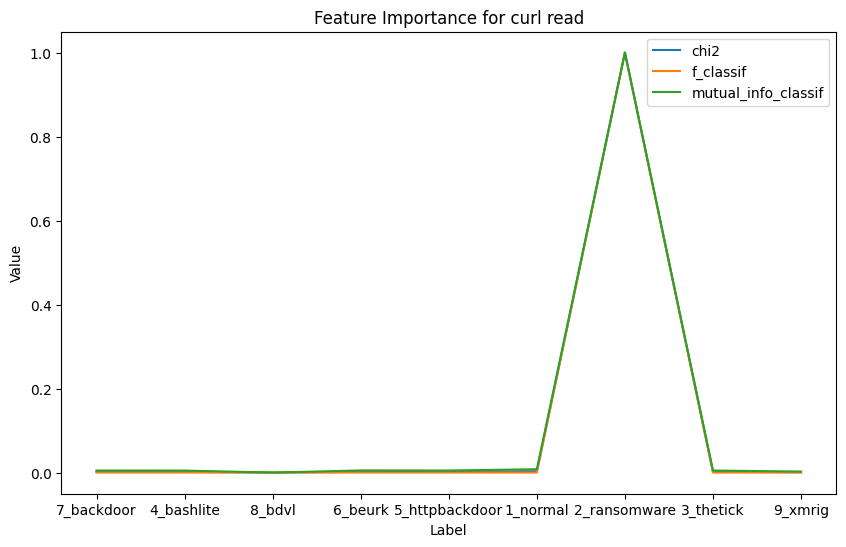

In [81]:
test_df = scores_by_label.copy()
feature_selection.sort_by_mean(test_df)
test_df.reset_index(inplace=True)
best_Feature = test_df.loc[0]["feature"]

feature_selection.plot_scores_by_label_single_plot_single_feature( scores_by_label, best_Feature)

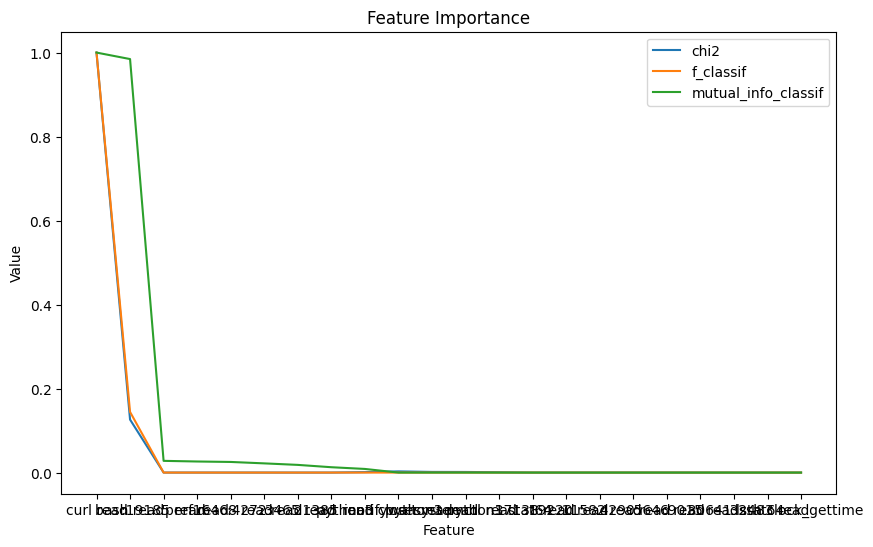

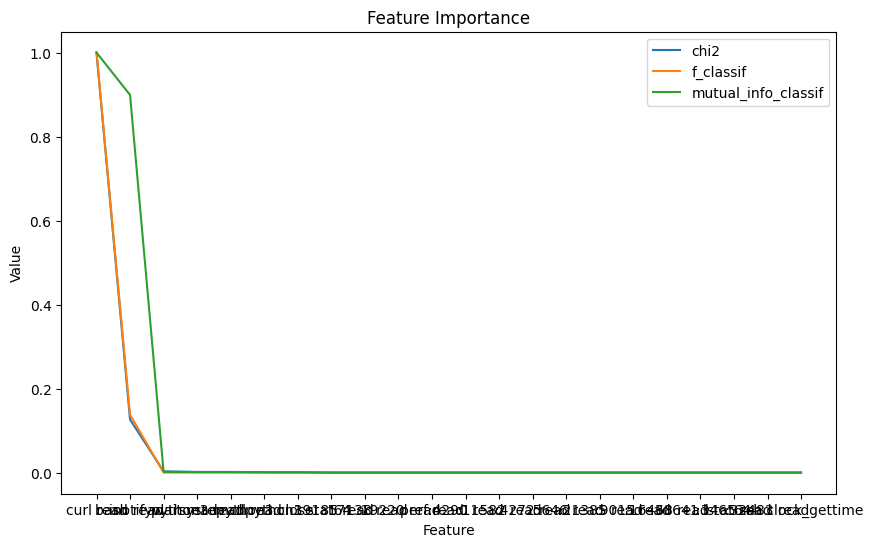

In [85]:
X1 = pd.DataFrame(X.toarray(), columns=cols)

scores = feature_selection.calculate_scores(X1, Y)
feature_selection.plot_single_scores(scores)

singles = singles.loc[scores["feature"].unique()]
singles = singles.reset_index()
feature_selection.plot_single_scores(singles)

# scores_robust = feature_selection.calculate_scores(X_ROBUST, Y_ROBUST)
# feature_selection.plot_single_scores(scores_robust)

2_ransomware
1_normal
6_beurk
7_backdoor
5_httpbackdoor
3_thetick
4_bashlite
9_xmrig
8_bdvl


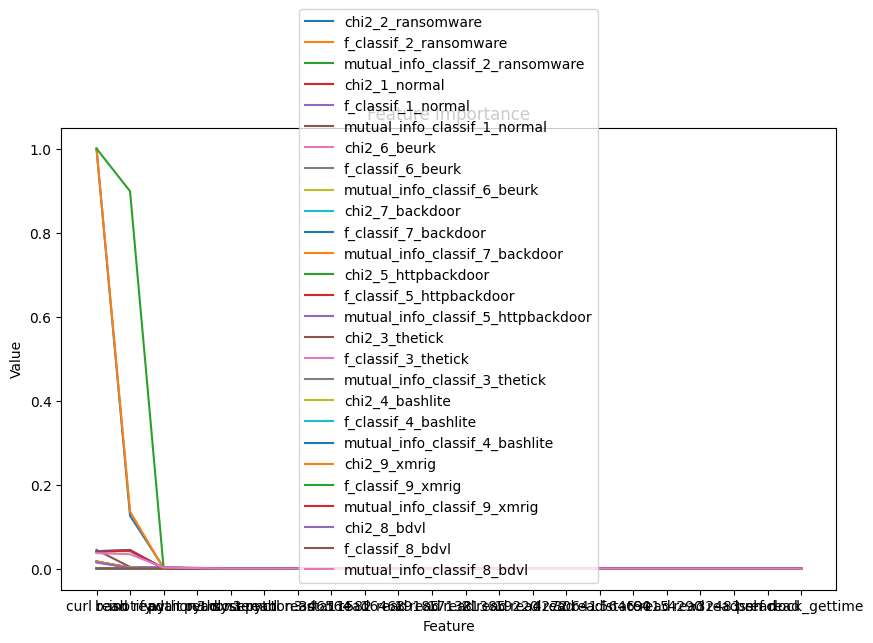

In [86]:
feature_selection.plot_scores_by_label_single_plot(scores_by_label)

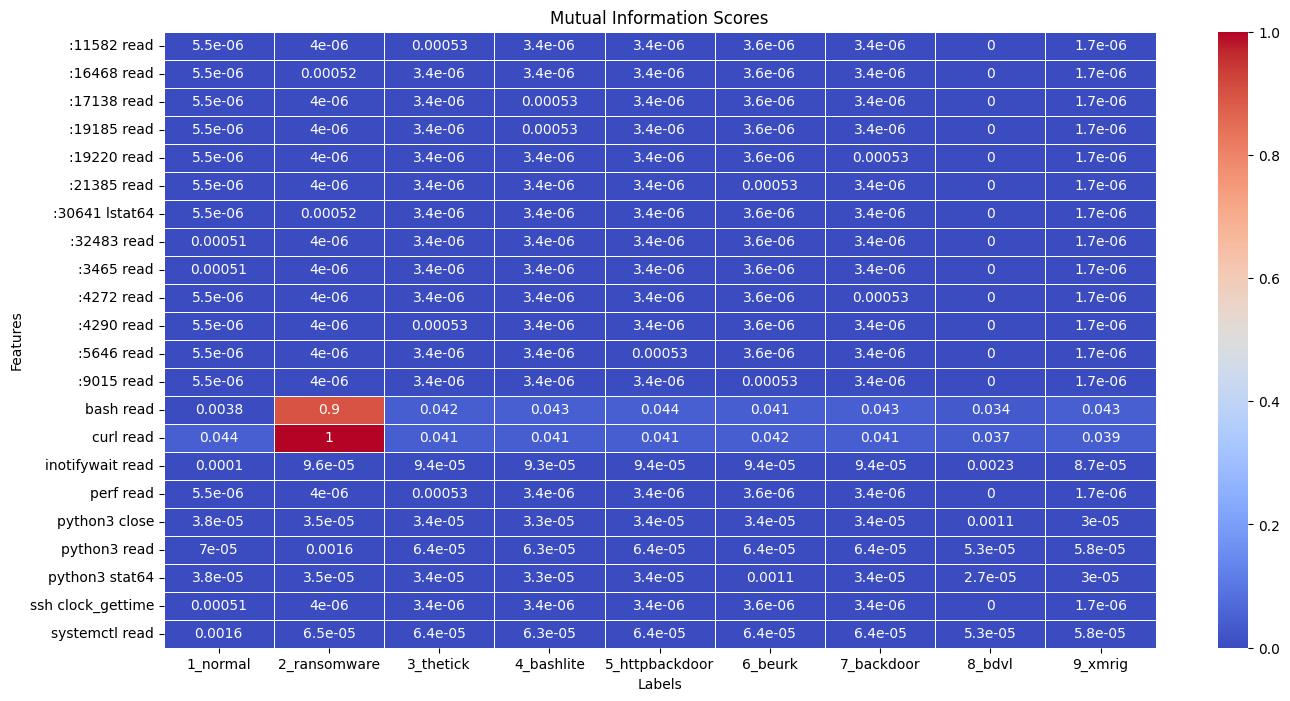

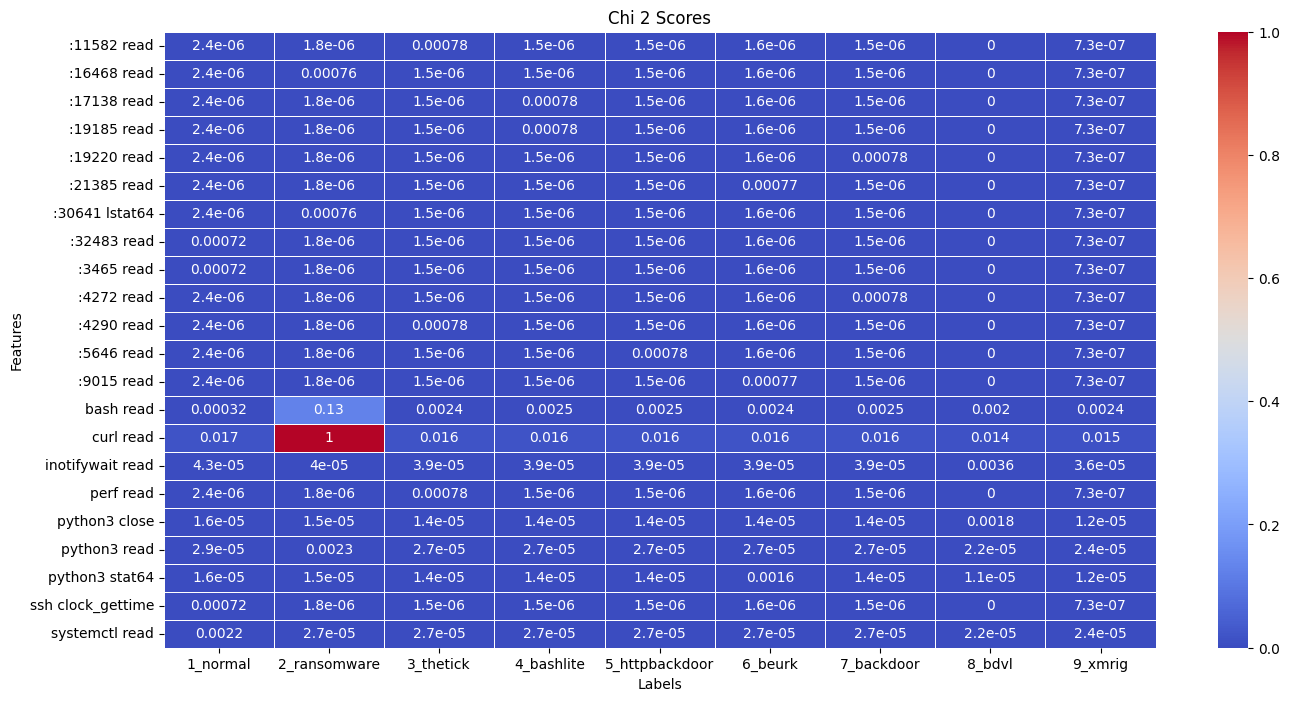

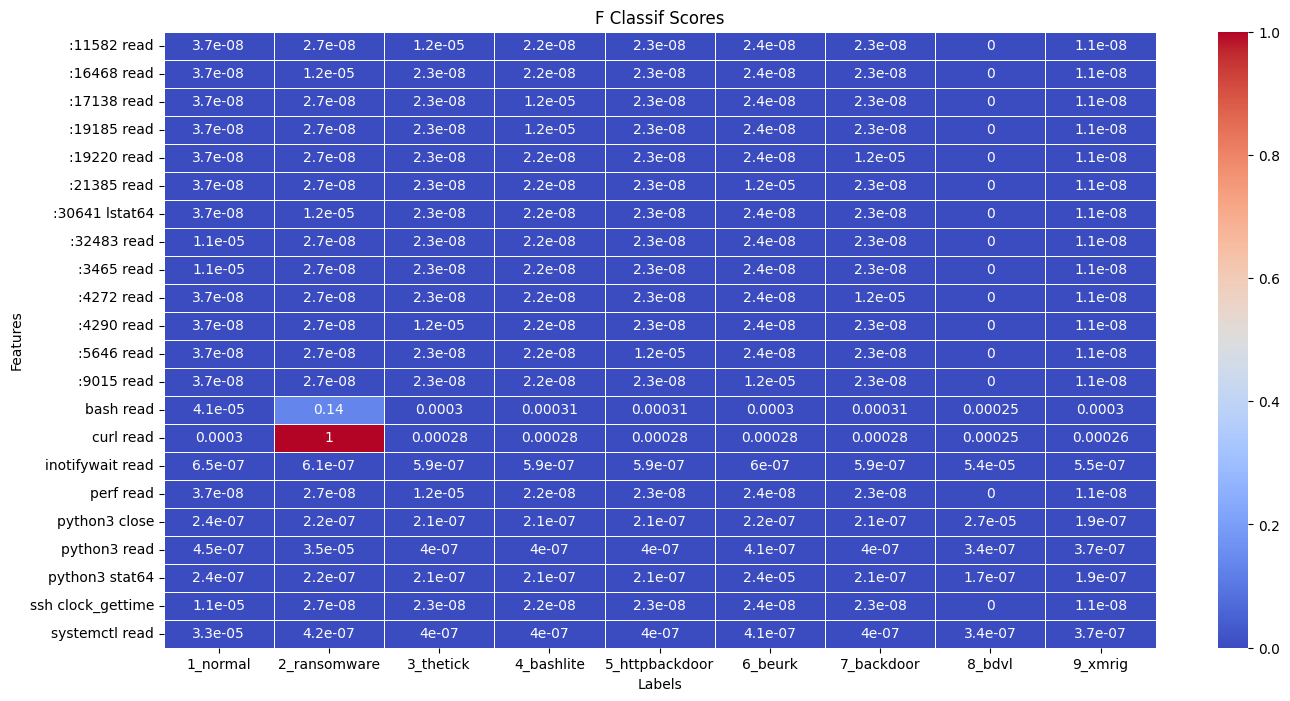

In [87]:
feature_selection.heatmap_scores_by_label_versus_features(scores_by_label)

In [ ]:
# scores_by_label_robust = feature_selection.calculate_scores_by_label(X_ROBUST, Y_ROBUST)
# feature_selection.heatmap_scores_by_label_versus_features(scores_by_label_robust)

In [ ]:
scores_by_label[""].unique()

#### Storing scores (modified for sys)

In [ ]:
output_dir = repo_base_path / "feature_selection" / "result"
output_file_X = output_dir / f"{DATA_SOURCE}{VERSION}_{DEVICE_SOURCE}_featurescores.csv"
output_file_X_ROBUST = output_dir / f"{DATA_SOURCE}{VERSION}_{DEVICE_SOURCE}_featurescores_ROBUST.csv"

In [ ]:
scores_by_label.to_csv(output_file_X, index=False)
scores_by_label_robust.to_csv(output_file_X_ROBUST, index=False)